In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## Importing libraires

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt

import os
import time
import copy

## Checking for 'cuda'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

## Visualizing the data count

In [10]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

In [11]:
def count_files_and_images(directory):
    class_counts = {}
    total_images = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            file_count = len(os.listdir(class_path))
            class_counts[class_name] = file_count
            total_images += file_count

    return class_counts, total_images

train_directory = train_dir
test_directory = test_dir

train_class_counts, total_train_images = count_files_and_images(train_directory)
test_class_counts, total_test_images = count_files_and_images(test_directory)

# Print the results
print("Train Directory:")
print("Class Counts:", train_class_counts)
print("Total Train Images:", total_train_images)

print("\nTest Directory:")
print("Class Counts:", test_class_counts)
print("Total Test Images:", total_test_images)

Train Directory:
Class Counts: {'pani puri': 2223, 'selroti': 2205, 'gajar ko halwa': 2160, 'lassi': 1992, 'biryani': 2226, 'kodo ko roti': 1596, 'laphing': 2187, 'buff curry': 1197, 'phini roti': 693, 'yomari': 2115, 'sekuwa': 1656, 'dalbhat': 1953, 'bhatmas sadeko': 1469, 'gundruk': 1326, 'chatamari': 1430, 'sisnu soup': 1029, 'chhoila': 1560, 'chhurpi': 1898, 'khaja set': 1788, 'khapse': 2097, 'dhido': 1890, 'thukpa': 1764, 'kakro ko achar': 1274, 'kheer': 1866, 'dhau(yogurt)': 1534, 'samosa': 1908, 'jeri(jalebi)': 2214, 'sukuti': 1625, 'chow mein': 1908, 'kwati': 1729, 'bara': 1848, 'chicken curry': 2376, 'momos': 2250, 'aalu chop': 2178}
Total Train Images: 61164

Test Directory:
Class Counts: {'pani puri': 62, 'selroti': 61, 'gajar ko halwa': 60, 'lassi': 83, 'biryani': 92, 'kodo ko roti': 19, 'laphing': 61, 'buff curry': 14, 'phini roti': 8, 'yomari': 58, 'sekuwa': 46, 'dalbhat': 54, 'bhatmas sadeko': 28, 'gundruk': 25, 'chatamari': 28, 'sisnu soup': 12, 'chhoila': 30, 'chhurpi'

In [12]:
dataset_sizes = {'train' : total_train_images, 'test' : total_test_images}

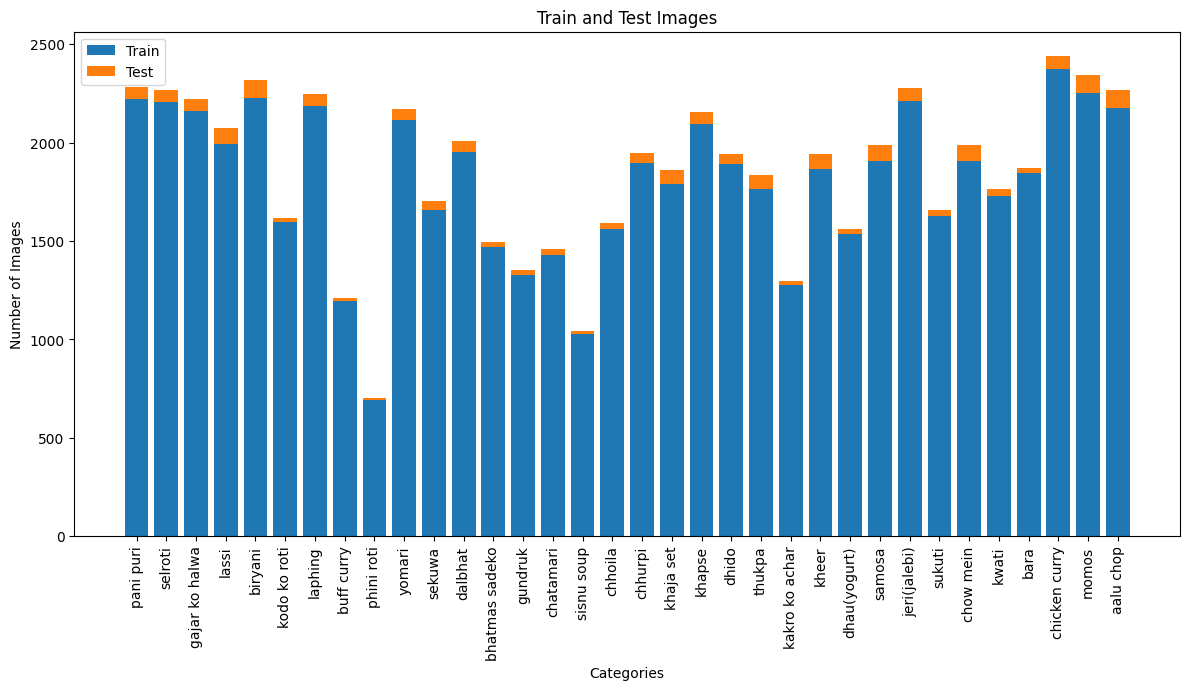

In [13]:
# Data
categories = [i for i in train_class_counts.keys()]
train_values = [i for i in train_class_counts.values()]
test_values = [i for i in test_class_counts.values()]

# Create bar graph
plt.figure(figsize=(12,6))
plt.bar(categories, train_values, label='Train')
plt.bar(categories, test_values, bottom=train_values, label='Test')

# Add title and labels
plt.title('Train and Test Images')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.tight_layout()

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Show the graph
plt.show()

## Hyperparameters

In [14]:
batch_size = 32
learning_rate = 0.001
step_size = 10
gamma = 0.1

num_classes = 34

# Image size
img_height = 224
img_width = 224

## Data Preprocessing

In [15]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

In [16]:
transform = transforms.Compose(
    [transforms.Resize((img_height, img_width)),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)])

In [17]:
sets = ['train', 'test']

image_datasets = {'train' : datasets.ImageFolder(train_dir, transform=transform),
                  'test' : datasets.ImageFolder(test_dir, transform=transform)}

dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
               for x in sets}

In [18]:
classes = image_datasets['train'].classes
print(classes)

['aalu chop', 'bara', 'bhatmas sadeko', 'biryani', 'buff curry', 'chatamari', 'chhoila', 'chhurpi', 'chicken curry', 'chow mein', 'dalbhat', 'dhau(yogurt)', 'dhido', 'gajar ko halwa', 'gundruk', 'jeri(jalebi)', 'kakro ko achar', 'khaja set', 'khapse', 'kheer', 'kodo ko roti', 'kwati', 'laphing', 'lassi', 'momos', 'pani puri', 'phini roti', 'samosa', 'sekuwa', 'selroti', 'sisnu soup', 'sukuti', 'thukpa', 'yomari']


## Data Visualization

In [19]:
# Function to show images
def imshow(ax, img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[label])
    ax.axis('off')  # Hide axes

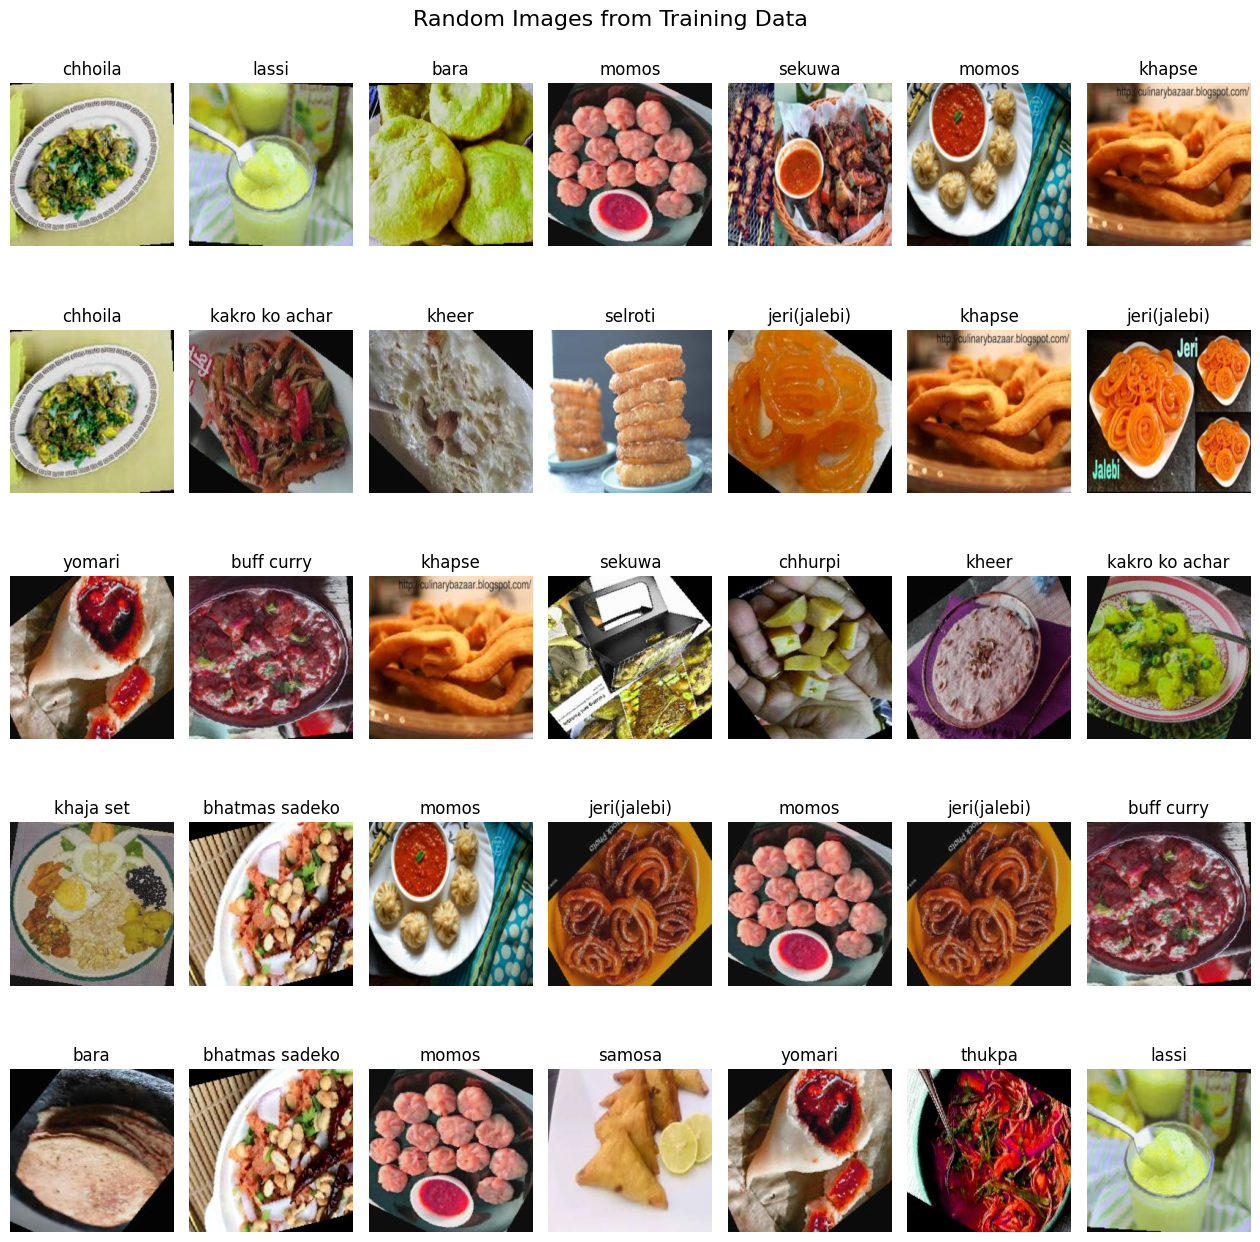

In [20]:
# Get some random training images
data_iter = iter(dataloaders['train'])
images, labels = next(data_iter)

# Plot the images in a grid
fig, axes = plt.subplots(5, 7, figsize=(16, 16))
fig.suptitle('Random Images from Training Data', fontsize=16, y=0.9)
plt.subplots_adjust(wspace=0.1, hspace=0)

for i in range(5):
    for j in range(7):
        index = np.random.randint(batch_size)
        ax = axes[i, j]
        imshow(ax, images[index], labels[index])
        ax.axis('off')

plt.show()

## Defining the training model

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    #Initialize lists to store training and validation metrics
    validation_metrics = {
        'train_acc_history' : [],
        'val_acc_history' : [],
        'train_loss_history' : [],
        'val_loss_history' : []
        }

    best_val_acc = 0.0

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if (i+1)%100 == 0:
                    print('=', end='')

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics in history lists
            if phase == 'train':
                validation_metrics['train_acc_history'].append(epoch_acc)
                validation_metrics['train_loss_history'].append(epoch_loss)
            else:
                validation_metrics['val_acc_history'].append(epoch_acc)
                validation_metrics['val_loss_history'].append(epoch_loss)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_val_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, validation_metrics

## Transfer Learning (resnet)

In [28]:
model = models.resnet18(weights=models.resnet.ResNet18_Weights.DEFAULT)
n_features = model.fc.in_features

n_features

512

In [29]:
model.fc = nn.Linear(n_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [31]:
model, validation_metrics = train_model(model, criterion, optimizer, step_lr_scheduler, 10)

Epoch 0/9
----------
===================train Loss: 0.9325 Acc: 0.7376
test Loss: 0.5725 Acc: 0.8266

Epoch 1/9
----------
===================train Loss: 0.2843 Acc: 0.9183
test Loss: 0.4853 Acc: 0.8548

Epoch 2/9
----------
===================train Loss: 0.1202 Acc: 0.9705
test Loss: 0.5204 Acc: 0.8537

Epoch 3/9
----------
===================train Loss: 0.0611 Acc: 0.9876
test Loss: 0.5115 Acc: 0.8629

Epoch 4/9
----------
===================train Loss: 0.0361 Acc: 0.9933
test Loss: 0.5197 Acc: 0.8641

Epoch 5/9
----------
===================train Loss: 0.0227 Acc: 0.9966
test Loss: 0.5364 Acc: 0.8600

Epoch 6/9
----------
===================train Loss: 0.0164 Acc: 0.9977
test Loss: 0.5324 Acc: 0.8687

Epoch 7/9
----------
===================train Loss: 0.0121 Acc: 0.9985
test Loss: 0.5192 Acc: 0.8733

Epoch 8/9
----------
===================train Loss: 0.0114 Acc: 0.9985
test Loss: 0.5363 Acc: 0.8652

Epoch 9/9
----------
===================train Loss: 0.0086 Acc: 0.9991
test Loss: 

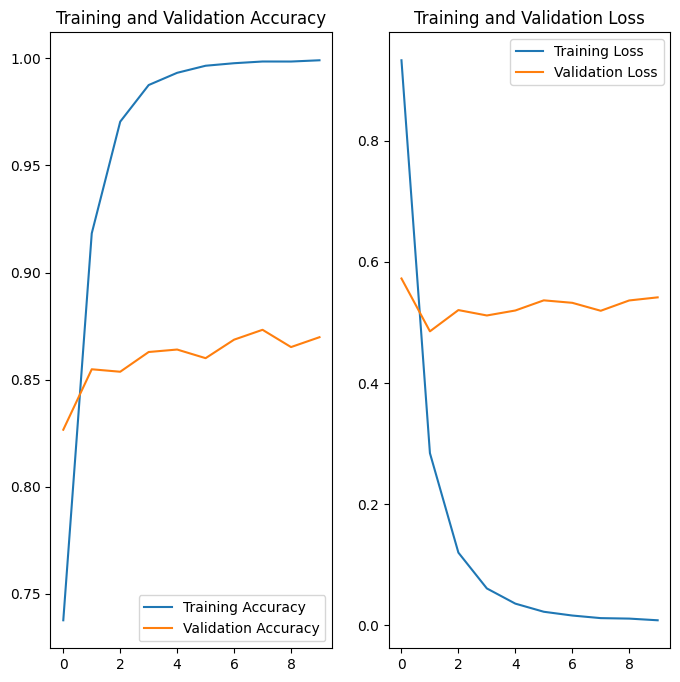

In [34]:
acc = [a.to('cpu') for a in validation_metrics['train_acc_history']]
val_acc = [v.to('cpu') for v in validation_metrics['val_acc_history']]

loss = validation_metrics['train_loss_history'][:]
val_loss = validation_metrics['val_loss_history'][:]

epochs_range = list(range(10))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving the model

In [35]:
torch.save(model, 'model.pth')